In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[ 68 128]
[  0  68 128 200]
[0.75 0.2  0.8 ]


Text(0, 0.5, 'Spikes')

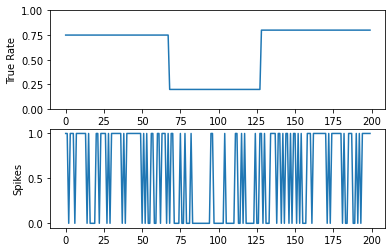

In [2]:
# Some poisson spiking
length = 200
states = 3
fit = int(1e5)
samples = 2000

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

#true_lambda = np.random.random(states)
true_lambda = np.array([0.75,0.2,0.8])

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros(length)
for num, val in enumerate(true_lambda):
    true_r[state_inds[num]:state_inds[num+1]] = val
  
spikes = np.random.random(length) < true_r
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].plot(true_r)
ax[0].set_ylim(0,1)
ax[1].plot(spikes)
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")

In [33]:
with pm.Model() as model:
    step_size = pm.Exponential("step_size", 0.05)
    lambda_latent = pm.GaussianRandomWalk("volatility", sigma=step_size, shape=length)
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=spikes)

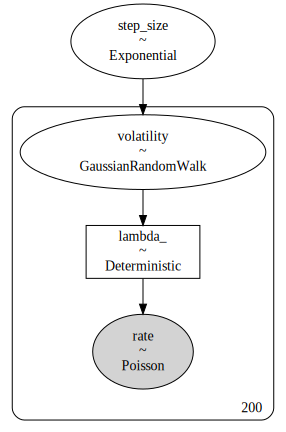

In [34]:
pm.model_to_graphviz(model)

In [35]:
with model:
    trace = pm.sample()
    
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=40000, method=inference)
#     trace = approx.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, step_size]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.5595296669123195, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [39]:
thinning = 10
trace = trace[::thinning]

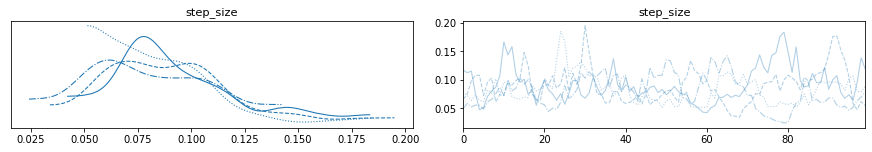

In [40]:
with model:
    pm.traceplot(trace, var_names = ['step_size'])

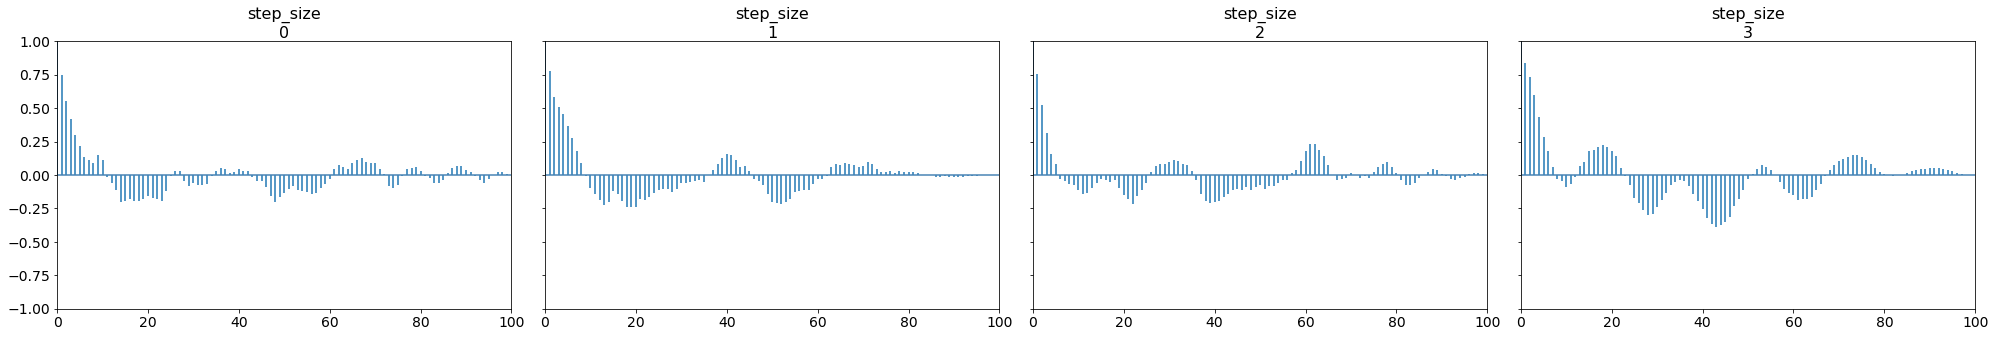

In [45]:
with model:
    pm.autocorrplot(trace, var_names = ['step_size']);

In [41]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model, var_names = ['lambda_'])

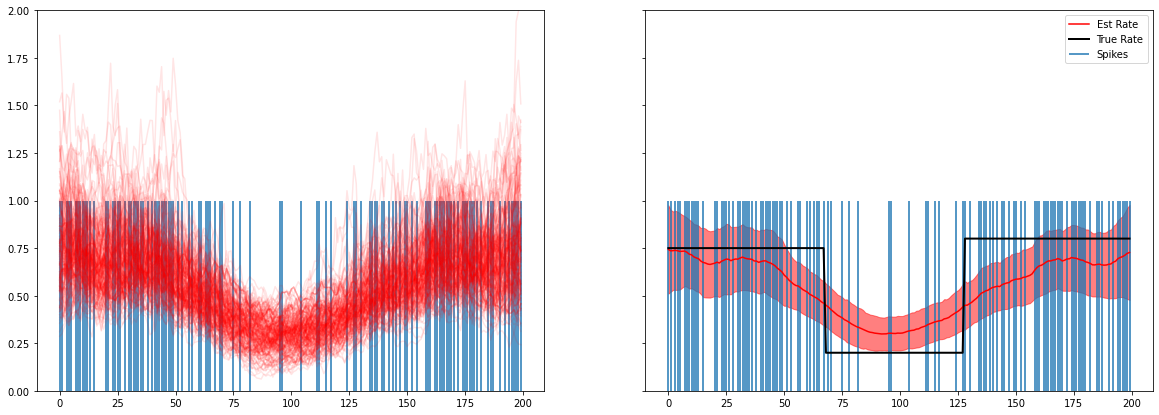

In [42]:
fig, ax = plt.subplots(1,2, figsize = (20,7), sharey = True)
plt.ylim(0,2);
ax[0].plot(ppc['lambda_'][:200].T, color = 'red', alpha = 0.1);
ax[0].vlines(np.where(spikes)[0], ymin = 0, ymax = 1);

ax[1].vlines(np.where(spikes)[0], ymin = 0, ymax = 1, label = 'Spikes');
mean_firing = np.mean(ppc['lambda_'],axis=0)
std_firing = np.std(ppc['lambda_'],axis=0)
ax[1].plot(mean_firing, color = 'red', label = 'Est Rate');
ax[1].fill_between(np.arange(length),
                    mean_firing - std_firing,
                      mean_firing + std_firing,
                  alpha = 0.5, color = 'red')
ax[1].plot(true_r, color = 'k', linewidth = 2, label = 'True Rate')
plt.legend()